## Install and Configure Ocean

We start by installing Ocean tool kit. Using your commandline, e.g bash, Anaconda, ..., excute

$ <b>pip install dwave-ocean-sdk</b>

Then we have to configure the tool kit so that it has access to DWAVE solvers. First retrieve the API token provided on the left panel of Leap dashboard (https://cloud.dwavesys.com/). Now create a config file using

$ <b>dwave config</b>
```
Using the simplified configuration flow.
Try 'dwave config create --full' for more options.

Creating new configuration file: /path/to/home/.config/dwave/dwave.conf
Profile [defaults]: ↵
Updating existing profile: ↵
Authentication token [skip]: ABC-1234567890abcdef1234567890abcdef ↵
Configuration saved.
```
You can verify your configuration with

$ <b>dwave ping --client qpu</b>

example output:
```
Using endpoint: https://cloud.dwavesys.com/sapi
Using solver: DW_2000Q_6
Submitted problem ID: 34f773f7-77dc-7fa5-a7d5-7e397d90fc4a

Wall clock time:
 * Solver definition fetch: 1888.499 ms
 * Problem submit and results fetch: 1038.042 ms
 * Total: 2926.541 ms

QPU timing:
 * post_processing_overhead_time = 307.0 us
 * qpu_access_overhead_time = 1185.96 us
 * qpu_access_time = 10995.04 us
 * qpu_anneal_time_per_sample = 20.0 us
 * qpu_delay_time_per_sample = 20.54 us
 * qpu_programming_time = 10756.1 us
 * qpu_readout_time_per_sample = 198.4 us
 * qpu_sampling_time = 238.94 us
 * total_post_processing_time = 307.0 us
```

## Increase your time with Developer Plan on DWave



In [10]:
import networkx as nx
import numpy as np

G = nx.Graph()

G.add_node(1,pos=(0,0))
G.add_node(2,pos=(1,0))
G.add_node(3,pos=(0,1))
G.add_node(4,pos=(1,1))

G.add_edge(1,2,weight = 5)
G.add_edge(1,3,weight = 5)
G.add_edge(2,4,weight = 2)
G.add_edge(3,4,weight = 10)
G.add_edge(2,3,weight = 2)

adjacency = nx.to_numpy_array(G)
edges = np.array(G.edges())

{(1, 2): Text(0.5, 0.0, '5'),
 (1, 3): Text(0.0, 0.5, '5'),
 (2, 4): Text(1.0, 0.5, '2'),
 (2, 3): Text(0.5, 0.5, '2'),
 (3, 4): Text(0.5, 1.0, '10')}

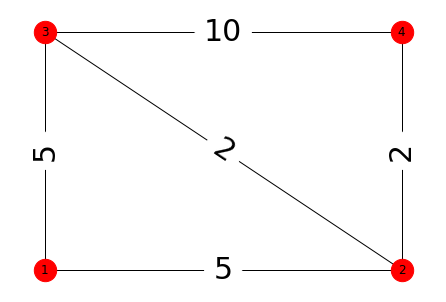

In [17]:
pos=nx.get_node_attributes(G,'pos')
nx.draw(G,pos,with_labels=True,node_color='red',node_size=500)
labels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_edge_labels(G,pos,edge_labels=labels,font_size=30)

We can find the shortest path using a classical algorithm (Dijkstra)

In [2]:
nx.dijkstra_path(G,1,4,weight=True)

[1, 2, 4]

In [18]:
H = np.zeros((len(edges)+adjacency.shape[0],len(edges)+adjacency.shape[0]))
source = 1
target = 2

alpha = 1
alpha_s = np.sum(adjacency)/2

for i in range(adjacency.shape[0],len(edges)+adjacency.shape[0]):
    for j in range(i,len(edges)+adjacency.shape[0]):
        edge1 = edges[i-adjacency.shape[0]]
        edge2 = edges[j-adjacency.shape[0]]
        
        if edge1[0] == edge2[0] or edge1[0] == edge2[1] or\
        edge1[1]==edge2[1] or edge1[1]==edge2[0]:
            if i == j:
                H[i,j] += (2*alpha_s+adjacency[edge1[0]-1,edge1[1]-1]*alpha)
            else:
                H[i,j] += 2*alpha_s
        else:
            continue
            
for i in range(adjacency.shape[0]):
    for j in range(adjacency.shape[0],len(edges)+adjacency.shape[0]):
        edge1 = edges[j-adjacency.shape[0]]
        
        if edge1[0] == i+1 or edge1[1] == i+1:
            if i != source-1 and i != target-1:
                H[i,j] += -4*alpha_s
            else:
                H[i,j] += -2*alpha_s
        else:
            continue
            
for i in range(adjacency.shape[0]):
    if i != source-1 and i != target-1:
        H[i,i] += 4*alpha_s

In [ ]:
off_set = 2*alpha_s
# off_set = off_set/np.max(np.abs(H))
max_adjacency = np.max(adjacency)
max_h = np.max(np.abs(H))
# H = H/np.max(np.abs(H))

In [ ]:
H_dict = {}
for i in range(H.shape[0]):
    for j in range(i,H.shape[0]):
        if H[i,j] == 0.0:
            continue
        H_dict.update({(i,j):H[i,j]})

In [ ]:
from dwave.system import LeapHybridSampler

result_dict = {}

lim = 10.0
for i in range(10): 
    sampler = LeapHybridSampler()
    results = sampler.sample_qubo(H_dict,time_limit=lim)
    res = []
    ener = []
    for rows in results.record:
        res.append(rows[0])
        ener.append(rows[1])

    result_dict.update({i+1:{'path':np.array(res),'energy':np.array(ener)}})
    
